# Bike Sharing Regression Portfolio

In this project we will investigate data from bike sharing company. Our target is to build a machine learning model to predict number of bike rentals based on various features.

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, mean_absolute_percentage_error

Quick look at the dataset and their columns :

    - instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit :
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

## Brief look

In [91]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


To begin with "instant" column doesn't provide any useful informations because it's a duplicated index column so we can delete them. "dteday" variable has one useful information we can extract - day of month. Lastly column "cnt" is a sum of casual and registered columns - we will deal with this fact later.

In [92]:
date_split = df.dteday.str.split("-")
df["day"] = date_split.str.get(2).astype("int")
df.drop(columns = ["dteday", "instant"], inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
 15  day         17379 non-null  int64  
dtypes: float64(4), int64(12)
memory usage: 2.1 MB


There are 17379 records with no missing values. All variables have appropriate data types.

Let's see if there are any duplicates.

In [94]:
df.isna().sum().sum()

0

Let's summarize continuous variables.

In [95]:
df[["temp", "atemp", "hum", "windspeed" ,"casual", "registered", "cnt"]].describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


This is how histograms and boxplots of this variables look like.

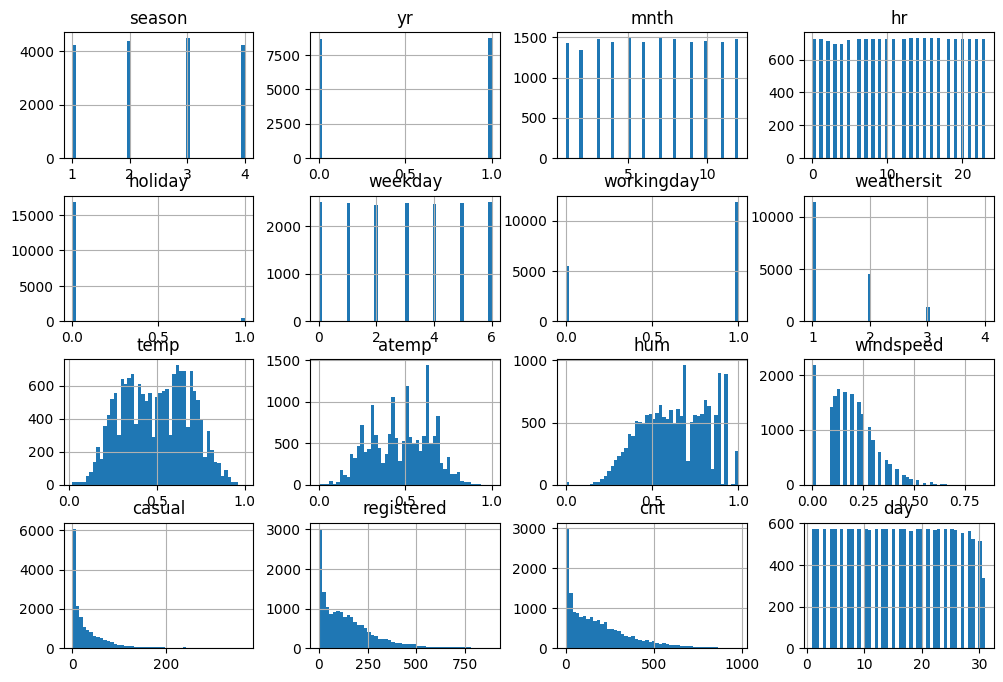

In [96]:
df.hist(bins=50, figsize=(12,8))
plt.show()

If we look at dates columns we can observe that observations were conducted regularly so we don't have to worry about bias. Majority of rides took place at good weather conditions. Temperature variable has distribution close to the normal distribution what means that people like riding the most when temperature is moderate. Humidity distribution is left skewed what means that very few rides took place at low humidity. Later we will need to deal with skewed data. On the other hand windspeed distribution is the complete opposite of humidity. Here we have right skewness what means that very few people rides when there's a high windy weather. If we look at number of rides in each category all have the same distribution - exponential.

<Figure size 1170x827 with 0 Axes>

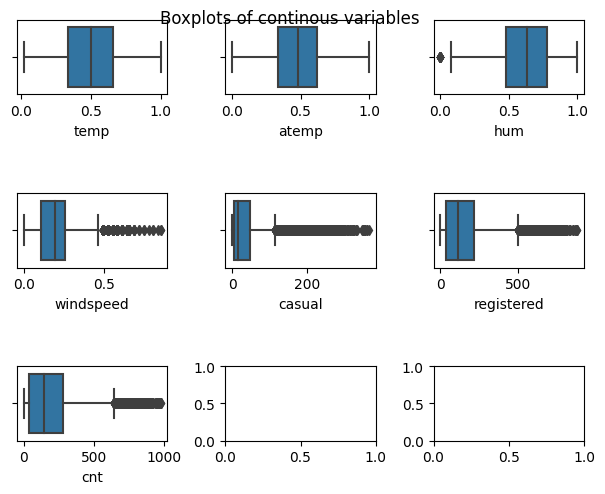

In [97]:
plt.figure(figsize=(11.7, 8.27))
fig, ax =plt.subplots(3,3)
fig.tight_layout(h_pad=5)
fig.suptitle('Boxplots of continous variables')
sns.boxplot(df, x="temp", ax=ax[0,0])
sns.boxplot(df, x="atemp", ax=ax[0,1])
sns.boxplot(df, x="hum", ax=ax[0,2])
sns.boxplot(df, x="windspeed", ax=ax[1,0])
sns.boxplot(df, x="casual", ax=ax[1,1])
sns.boxplot(df, x="registered", ax=ax[1,2])
sns.boxplot(df, x="cnt", ax=ax[2,0])
plt.show()

Now it's time for the rest of variables.

In [100]:
value_count_columns = ["season", "yr", "mnth", "day", "hr", "holiday", "weekday", "workingday", "weathersit"]
for column in value_count_columns:
    print(df[column].value_counts())
    print("---------------------")

3    4496
2    4409
4    4232
1    4220
Name: season, dtype: int64
---------------------
1    8734
0    8623
Name: yr, dtype: int64
---------------------
5     1488
7     1488
12    1483
8     1475
3     1451
10    1451
6     1440
4     1437
9     1437
11    1437
1     1429
2     1341
Name: mnth, dtype: int64
---------------------
1     575
5     575
17    575
9     575
13    574
21    574
20    574
19    574
15    574
14    574
16    574
8     574
7     574
4     574
12    573
23    573
2     573
24    573
3     573
25    572
6     572
22    569
11    568
26    567
18    563
28    563
27    552
10    550
29    526
30    514
31    336
Name: day, dtype: int64
---------------------
17    729
16    729
13    728
15    728
14    728
12    727
22    727
21    727
20    727
19    727
18    727
23    727
11    726
10    726
9     726
8     726
7     726
0     725
6     724
1     723
5     716
2     714
4     697
3     697
Name: hr, dtype: int64
---------------------
0    16857
1      500
Name

## EDA

Let's move on to some EDA techniques to better understand our data.

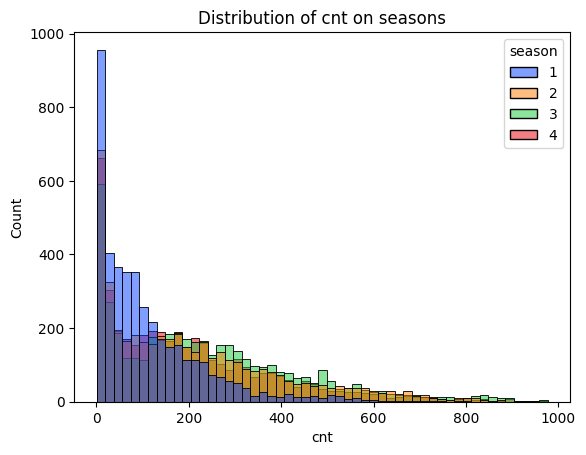

In [101]:
sns.histplot(df, x = 'cnt', hue = 'season', palette="bright")
plt.title("Distribution of cnt on seasons")
plt.show()

The smallest amount of rentals take place during spring but the largest surprisingly on autumn.

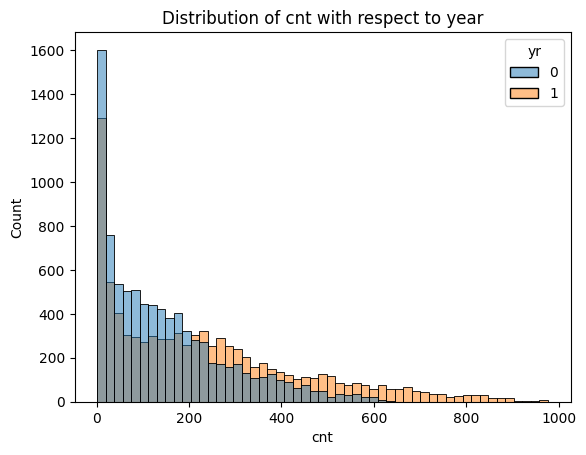

In [102]:
sns.histplot(df, x = 'cnt', hue = 'yr')
plt.title("Distribution of cnt with respect to year")
plt.show()

When it comes to large rentals per hour more took place in 2012.

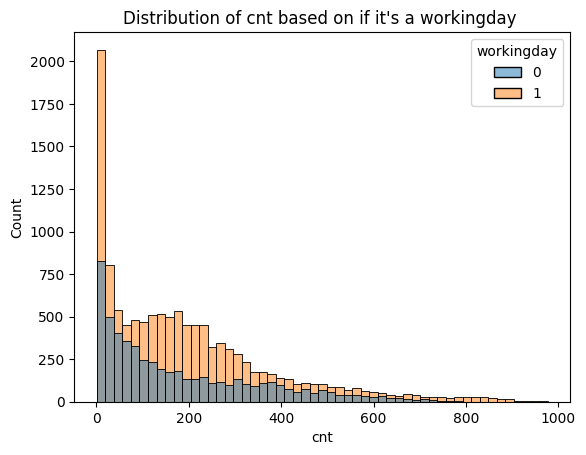

In [103]:
sns.histplot(df, x='cnt', hue = 'workingday')
plt.title("Distribution of cnt based on if it's a workingday ")
plt.show()

People tend to rent more bikes on workingdays.

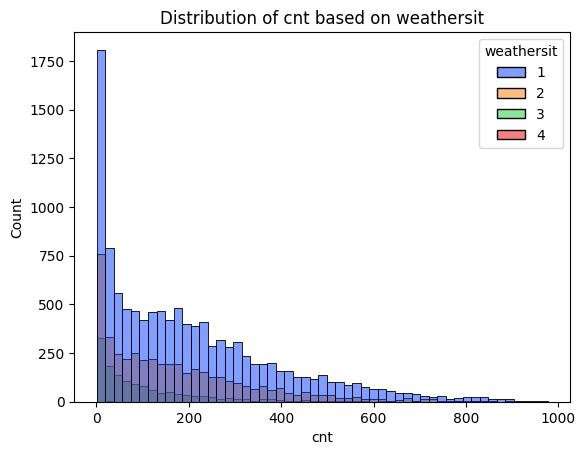

In [104]:
sns.histplot(df, x='cnt', hue = 'weathersit', palette="bright")
plt.title("Distribution of cnt based on weathersit")
plt.show()

Most likely people are renting bikes when it's a good weather.

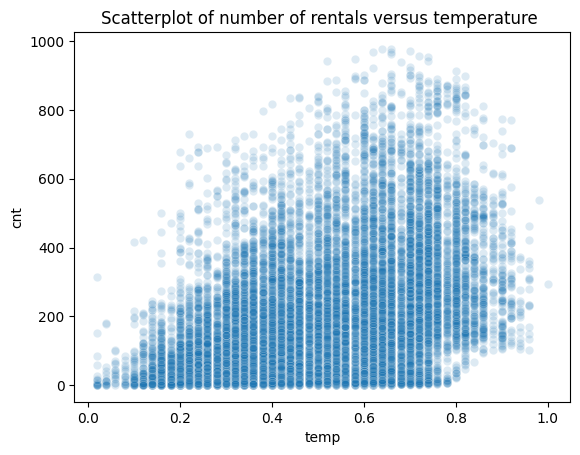

In [105]:
sns.scatterplot(df, x= 'temp', y='cnt', alpha = 0.15)
plt.title("Scatterplot of number of rentals versus temperature ")
plt.show()

It's pretty obvious to say that people like riding when it's warm.

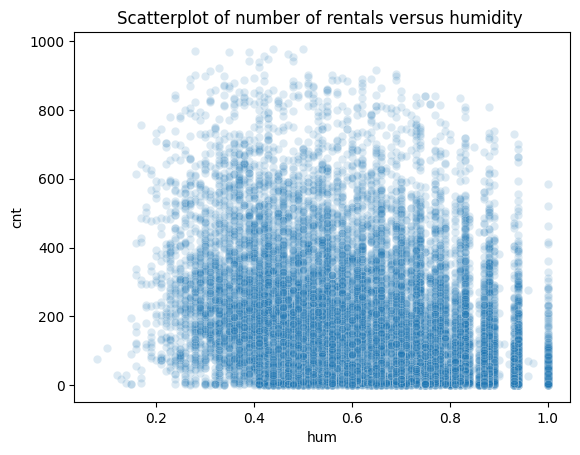

In [106]:
sns.scatterplot(df, x='hum', y='cnt', alpha = 0.15)
plt.title("Scatterplot of number of rentals versus humidity ")
plt.show()

When humidity is raising the number of rentals is slowly decreasing.

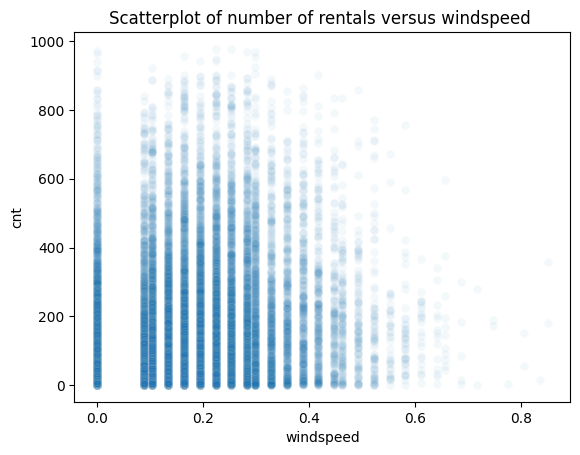

In [107]:
sns.scatterplot(df, x='windspeed', y='cnt', alpha = 0.05)
plt.title("Scatterplot of number of rentals versus windspeed ")
plt.show()

When windspeed is raising the number of rentals is slowly decreasing.

## Train test split

It's time to split our dataset into train and test one with proportion 80/20.

In [108]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Let's see if continuous variables are linearly correlated.

## Correlation

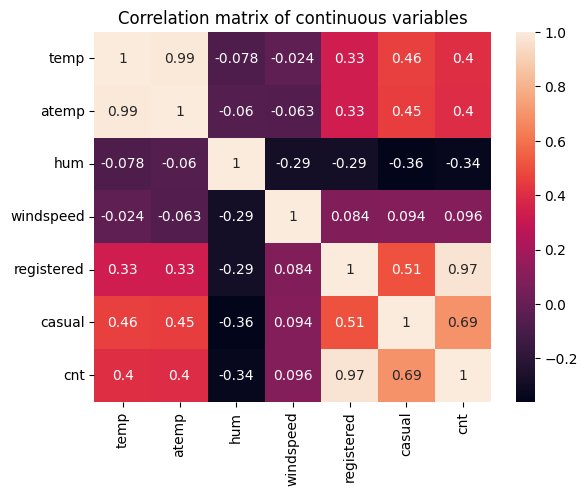

In [109]:
corr_matrix = train_set[["temp", "atemp", "hum", "windspeed", "registered", "casual", "cnt"]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation matrix of continuous variables")
plt.show()

Since temperature and feeling temperature are highly correlated we will drop one of them to simplify model. The same thing we will do with registered and casual columns.

In [110]:
corr_matrix["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972435
casual        0.694591
temp          0.402307
atemp         0.399143
windspeed     0.095769
hum          -0.335446
Name: cnt, dtype: float64

This output presents how feautures are correlated to cnt variable.

In [111]:
train_set.drop(columns = ["registered", "atemp"], inplace = True)
test_set.drop(columns = ["registered", "atemp"], inplace = True)

Now we will separate features from out target - cnt.

In [112]:
x_train = train_set.drop(columns = ["casual", "cnt"])
y_train = train_set["cnt"]

x_test = test_set.drop(columns = ["casual", "cnt"])
y_test = test_set["cnt"]

## Transformations

As we spotted previously we have some features with skewness. We need to transform them before scaling data to the model. For right skew we will use logarithm transformation. Below we can see code of our log transformer.

In [113]:
def log_transformer_function(X):
    X = X.tolist()
    for i in range(len(X)):
        if X[i] > 0:
            X[i] = np.log(X[i]+1)
        elif X[i] == 0:
            X[i] = 0
    return pd.Series(X)

In [114]:
def log_transformer_inverse(X):
    X = X.tolist()
    for i in range(len(X)):
        X[i] = np.power(np.e, X[i]) - 1
    return pd.Series(X)

In [115]:
log_transformer = FunctionTransformer(log_transformer_function, inverse_func=log_transformer_inverse)

For left skew we will use a square transform.

In [116]:
square_transformer = FunctionTransformer(np.square, inverse_func=np.sqrt)

Let's apply both transformations to our data.

In [117]:
x_train["windspeed"] = list(log_transformer.fit_transform(x_train["windspeed"]))
x_test["windspeed"] = list(log_transformer.transform(x_test["windspeed"]))

In [118]:
x_train["hum"] = list(square_transformer.fit_transform(x_train["hum"]))
x_test["hum"] = list(square_transformer.transform(x_test["hum"]))

Since many of our predictors has date characteristic in order to preserve their properties we will use sin-cos transformation.

In [119]:
time_cols = ["hr", "day", "weekday", "mnth", "season"]
time_pipeline = make_pipeline(CyclicalFeatures(variables=time_cols, drop_original=True))

x_train = time_pipeline.fit_transform(x_train)
x_test = time_pipeline.transform(x_test)

colnames = x_train.columns

The last transformation is scaling our dataset. Here we will use MinMax transformation.

In [120]:
scaler_pipeline = make_pipeline(MinMaxScaler())

x_train = scaler_pipeline.fit_transform(x_train)
x_test = scaler_pipeline.transform(x_test)

x_train = pd.DataFrame(x_train, columns=colnames)
x_test = pd.DataFrame(x_test, columns=colnames)

## Applying models

The metric we will use to rate our models predictions is root mean squared error. Below you can see simple function conducting cross validation using our metric.

In [121]:
def cross_val(regressor):
    model = regressor
    model.fit(x_train, y_train)
    rmses = -cross_val_score(model, x_train, y_train, scoring ="neg_root_mean_squared_error", cv=10)
    return rmses

In this project we will use following algorithms:

- Linear Regression
- KNeighors Regression
- Decision Tree Regressor
- Random Forest Regressor
- Extra Tree Regressor
- Gradient Boosting Regressor
- Adaptive Boost Regressor
- CatBoost Regressor
- Light Gradient Boosting Regressor
- Extreme Gradient Boosting Regressor


In [122]:
models = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), CatBoostRegressor(verbose=False), LGBMRegressor(), XGBRegressor()]

Let's use selected models and save the results.

In [ ]:
scores = []
for model in models:
    score = cross_val(model)
    scores.append(score)

To compare models' score we will use boxplots.

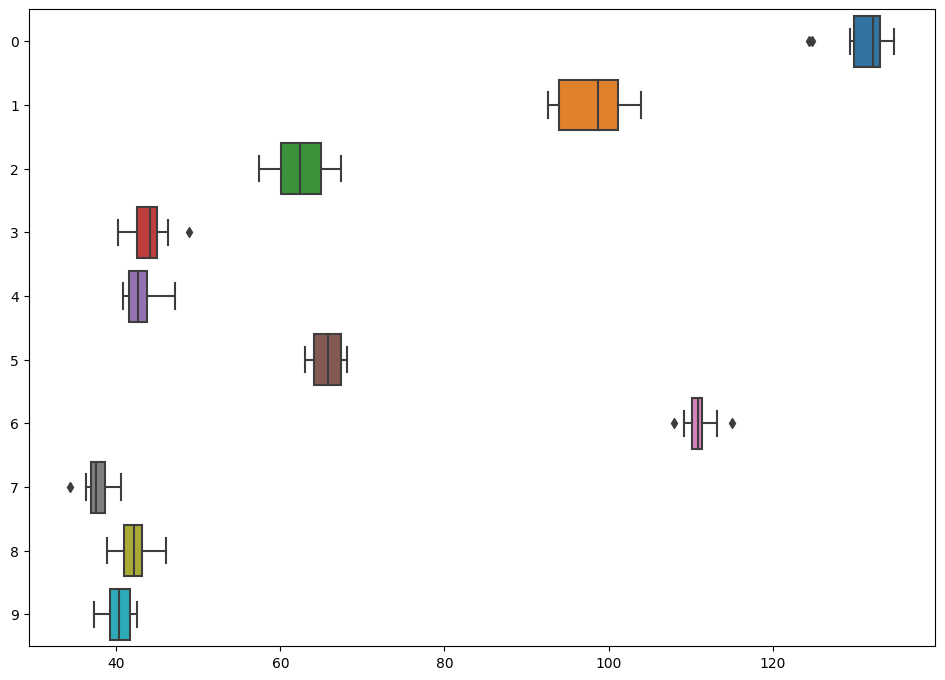

In [124]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.boxplot(scores, ax = ax,  orient="h")
plt.show()

## Hyperparameter Tuning

Let's recall that the lower score is the better model we have. Below we selected 5 best working models. Now we want to experiment with different hyperparameters to see if we can improve them more. We will use GridSearchCV to automatize everything.

In [125]:
best_models = [RandomForestRegressor(), ExtraTreesRegressor(), CatBoostRegressor(verbose=False), LGBMRegressor(), XGBRegressor()]

In [126]:
models_hyperparameters = [[RandomForestRegressor(), { 'n_estimators': [ 50, 100, 150], 'max_features': ['sqrt', 'log2', None], 'max_leaf_nodes': [3, 6, 9], 'min_samples_leaf' : [1,2,3]}], [ExtraTreesRegressor(), { 'n_estimators': [ 50, 100, 150], 'max_features': ['sqrt', 'log2', None], 'max_leaf_nodes': [3, 6, 9], 'min_samples_leaf' : [1,2,3]}], [CatBoostRegressor(verbose=False), {'depth': [6,8,10], 'learning_rate' : [0.01, 0.05, 0.001, 0.1],  'iterations' : [ 50, 100, 150]}], [LGBMRegressor(), {'learning_rate': [0.05, 0.01, 0.001], 'n_estimators': [50, 100, 200, 500]}], [XGBRegressor(), {'learning_rate' : [0.001, 0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}]]

In [ ]:
grid_results = []
for model in models_hyperparameters:
    grid = GridSearchCV(model[0], model[1], cv=5, scoring = 'neg_root_mean_squared_error')
    grid.fit(x_train, y_train)
    grid_results.append(pd.DataFrame(grid.cv_results_))

Now let's see if our models improved. We will print best score of each models.

In [137]:
for i in range(len(grid_results)):
  print(str(best_models[i]) +" :" +str(-np.max(grid_results[i].mean_test_score)))

RandomForestRegressor() :110.86211241909227
ExtraTreesRegressor() :108.86875504511814
<catboost.core.CatBoostRegressor object at 0x7ef6dee358a0> :38.63155271160347
LGBMRegressor() :40.017836908609596
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) :38.890702983731536


As you can see tuning hyperparameters hasn't improved our models.

## Feauture importance

Still we can get some useful informations like importance of particular features in currently best model.

In [129]:
model_catboost = CatBoostRegressor(verbose=False)
model_catboost.fit(x_train, y_train)
feature_importance = model_catboost.feature_importances_
sorted(zip(feature_importance,model_catboost.feature_names_),reverse=True)

[(32.259425744096845, 'hr_sin'),
 (28.110467325955632, 'hr_cos'),
 (8.902018594179863, 'temp'),
 (8.626538549093572, 'workingday'),
 (7.758744747126567, 'yr'),
 (3.4010057696677287, 'weekday_cos'),
 (3.233841787660235, 'season_sin'),
 (2.136641900806358, 'hum'),
 (1.6606045203718676, 'weathersit'),
 (0.9044137801664105, 'mnth_sin'),
 (0.6014894024983352, 'day_sin'),
 (0.5334334774509288, 'mnth_cos'),
 (0.5239449236920531, 'weekday_sin'),
 (0.44244422568719427, 'season_cos'),
 (0.4131116794280499, 'day_cos'),
 (0.32233523615736764, 'windspeed'),
 (0.16953833596098372, 'holiday')]

We can say that most important features to predict cnt are Hour, Temperature, Workingday and Year.

It's time to compare machine learning models to deep learning one. We will use neural network and see if it's better than best current model - CatBoost.

## Neural Network

In [130]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.mean_squared_error(y_true, y_pred))

def design_model(features):
    model = Sequential(name = "Neural_Network")
    input = InputLayer(input_shape = (x_train.shape[1],))
    model.add(input)
    hidden_layer = layers.Dense(1024, activation='relu')
    model.add(hidden_layer)
    hidden_layer_2 = layers.Dense(512, activation='relu')
    model.add(hidden_layer_2)
    hidden_layer_3 = layers.Dense(256, activation='relu')
    model.add(hidden_layer_3)
    hidden_layer_4 = layers.Dense(128, activation='relu')
    model.add(hidden_layer_4)
    hidden_layer_5 = layers.Dense(64, activation='relu')
    model.add(hidden_layer_5)
    model.add(layers.Dense(1))
    opt = Adam(learning_rate = 0.001)
    model.compile(loss = rmse, metrics = mean_absolute_percentage_error, optimizer = opt)
    return model

model = design_model(x_train)
es = EarlyStopping(monitor = "val_loss", mode="min", verbose=1, patience = 10)
model.summary()

Model: "Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 1024)              18432     
                                                                 
 dense_24 (Dense)            (None, 512)               524800    
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 715777 (2.73 MB)
Trainable params: 715

Above you can see the structure of neural network.

In [131]:
history = model.fit(x_train, y_train, epochs=150, batch_size= 32, verbose=1, validation_split = 0.25, callbacks = [es])

Epoch 1/150
326/326 [==============================] - 7s 17ms/step - loss: 88.1807 - mean_absolute_percentage_error: 152.6379 - val_loss: 62.4893 - val_mean_absolute_percentage_error: 75.2315
Epoch 2/150
326/326 [==============================] - 6s 18ms/step - loss: 57.9072 - mean_absolute_percentage_error: 56.9465 - val_loss: 56.1951 - val_mean_absolute_percentage_error: 60.3003
Epoch 3/150
326/326 [==============================] - 5s 16ms/step - loss: 47.8090 - mean_absolute_percentage_error: 43.9239 - val_loss: 45.0491 - val_mean_absolute_percentage_error: 46.1193
Epoch 4/150
326/326 [==============================] - 5s 16ms/step - loss: 40.2777 - mean_absolute_percentage_error: 38.2031 - val_loss: 37.0331 - val_mean_absolute_percentage_error: 34.5643
Epoch 5/150
326/326 [==============================] - 6s 18ms/step - loss: 34.3133 - mean_absolute_percentage_error: 34.6355 - val_loss: 43.4132 - val_mean_absolute_percentage_error: 44.2483
Epoch 6/150
326/326 [==================

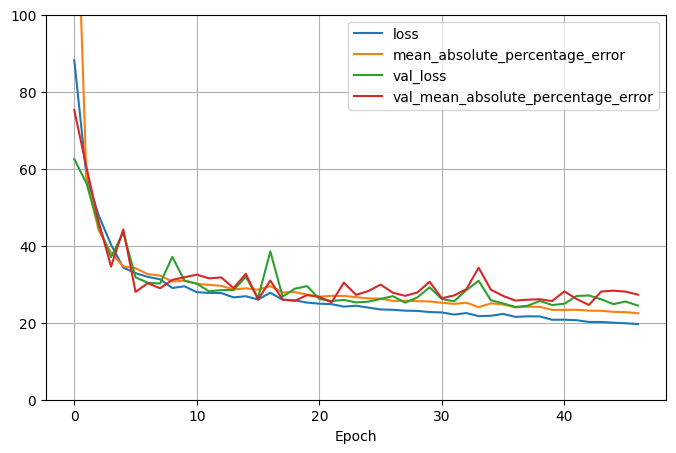

In [132]:
pd.DataFrame(history.history).plot(figsize=(8, 5), ylim=[0, 100], grid=True, xlabel="Epoch")
plt.show()

See how fast network learns the data. This model is even better than CatBoost so this is a final one.

## Evaluation on test set

It's time to evalute best model - neural network on a set that network has never seen before - test set. Now we will see how good our model really is. Let's see the results.

In [133]:
val_rmse, val_mape = model.evaluate(x_test, y_test, verbose = 0)
final_predictions = model.predict(x_test)[0]
print("Results:")
print("RSME: " + str(val_rmse) +", MAPE: " + str(val_mape))

109/109 [==============================] - 1s 6ms/step
Results:
RSME: 24.93132781982422, MAPE: 26.479740142822266


## Summary

Usually performance on test set is slightly worse than on train one - that's obvious. Even though our model is making really small errors on predicting number of rentals per hour.

Your job is done. In the end we will save the model.

In [134]:
model.save("bike_rental_neural_network", save_format="tf")